In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
import random

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

pyro.enable_validation(True)

In [2]:
# generating simulated data
def generate_data(group):
    #diagonal group
    if group == 'diag':
        dat = dist.Dirichlet(torch.tensor([[5.,1.,1.,1.,1.],
                                           [1.,5.,1.,1.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,1.,1.,5.],
                                            [1.,1.,1.,1.,5.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,5.,1.,1.,1.],
                                            [5.,1.,1.,1.,1.],
                                            [5.,1.,1.,1.,1.],
                                            [1.,5.,1.,1.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,1.,1.,5.]])).sample()
    # one side group
    elif group == 'side':
        dat = dist.Dirichlet(torch.tensor([[5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.]])).sample()
    return dat
    


random.seed(680814)
data = torch.stack([generate_data('diag') for i in range(100)] +
                   [generate_data('side') for i in range(100)],dim=0)
#print(data)
print(data.shape)
# data = data.permute([2,1,0])
# print(data.shape)

torch.Size([200, 15, 5])


In [90]:
K = 100  # Fixed number of components.

@config_enumerate()
def model(data):
    # Background probability of different groups (assume equally likely)
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
    with pyro.plate('components', K):
        # concentration parameters
        concentration = pyro.sample('concentration', dist.Gamma(2 * torch.ones(15,5), 1/3 * torch.ones(15,5)).to_event(2))
#         print(concentration.dtype)
        
    with pyro.plate('data', data.shape[0]):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        #d = dist.Dirichlet(concentration[assignment,:,:].clone().detach()) # .detach() might interfere with backprop
        d = dist.Dirichlet(concentration[assignment,:,:])
        #print(d.to_event(1).batch_shape, d.to_event(1).event_shape)

        pyro.sample('obs', d.to_event(1), obs=data)

In [78]:
model(data)

torch.float32


In [238]:
# K = 2  # Fixed number of components.

# @config_enumerate()
# def model(data):
#     # Background probability of different groups (assume equally likely)
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
# #    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
#     with pyro.plate('components', K):
#         # concentration parameters
#         concentration1 = pyro.sample('concentration1', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration2 = pyro.sample('concentration2', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration3 = pyro.sample('concentration3', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration4 = pyro.sample('concentration4', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration5 = pyro.sample('concentration5', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         print('concentration: ',concentration1.shape)
        
#     with pyro.plate('data', data.shape[0]):
#         # Local variables.
#         assignment = pyro.sample('assignment', dist.Categorical(weights))
# #         print('assignment', assignment)
# #         print('indexed by assignment',concentration1[assignment])
#         d = dist.Dirichlet(torch.stack([concentration1[assignment,:],
#                                          concentration2[assignment,:],
#                                          concentration3[assignment,:],
#                                          concentration4[assignment,:],
#                                          concentration5[assignment,:]],dim = 2))

#         #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
#         pyro.sample('obs', d.to_event(1), obs=data)
        

In [234]:
# # still wrong
# K = 2  # Fixed number of components.

# @config_enumerate()
# def model(data):
#     # Background probability of different groups (assume equally likely)
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
# #    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
#     with pyro.plate('components', K):
#         # concentration parameters
#         concentration1 = pyro.sample('concentration1', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration2 = pyro.sample('concentration2', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration3 = pyro.sample('concentration3', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration4 = pyro.sample('concentration4', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration5 = pyro.sample('concentration5', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration6 = pyro.sample('concentration6', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration7 = pyro.sample('concentration7', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration8 = pyro.sample('concentration8', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration9 = pyro.sample('concentration9', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration10 = pyro.sample('concentration10', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration11 = pyro.sample('concentration11', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration12 = pyro.sample('concentration12', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration13 = pyro.sample('concentration13', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration14 = pyro.sample('concentration14', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration15 = pyro.sample('concentration15', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         print('concentration: ',concentration1)
        
#     with pyro.plate('data', data.shape[0]):
#         # Local variables.
#         assignment = pyro.sample('assignment', dist.Categorical(weights))
# #         print('assignment', assignment)
# #         print('indexed by assignment',concentration1[assignment])
# #         print(torch.stack([concentration1[assignment],concentration2[assignment]],dim = 1))
#         d = dist.Dirichlet(torch.stack([concentration1[assignment,:],
#                                          concentration2[assignment,:],
#                                          concentration3[assignment,:],
#                                          concentration4[assignment,:],
#                                          concentration5[assignment,:],
#                                          concentration6[assignment,:],
#                                          concentration7[assignment,:],
#                                          concentration8[assignment,:],
#                                          concentration9[assignment,:],
#                                          concentration10[assignment,:],
#                                          concentration11[assignment,:],
#                                          concentration12[assignment,:],
#                                          concentration13[assignment,:],
#                                          concentration14[assignment,:],
#                                          concentration15[assignment,:]],dim = 1))

#         #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
#         pyro.sample('obs', d.to_event(1), obs=data)
        

In [19]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def initialize(seed):           
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentration']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(100)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 76, initial_loss = 19180.939453125


In [21]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(3000):
    loss = svi.step(data)
    print(loss)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

map_estimates = global_guide(data)
concentration = map_estimates['concentration']
# print('alphas = {}'.format(alphas.data.numpy()))
# print('betas = {}'.format(betas.data.numpy()))
print('concentrations = {}'.format(concentration.data.numpy()))

17242.8515625

17208.50390625
.17174.16015625
.17139.857421875
.17105.5703125
.17071.31640625
.17037.087890625
.17002.888671875
.16968.70703125
.16934.564453125
.16900.44140625
.16866.345703125
.16832.28515625
.16798.248046875
.16764.2421875
.16730.26171875
.16696.31640625
.16662.384765625
.16628.5
.16594.62890625
.16560.794921875
.16526.98046875
.16493.201171875
.16459.427734375
.16425.69140625
.16391.970703125
.16358.26953125
.16324.587890625
.16290.9248046875
.16257.287109375
.16223.6435546875
.16190.0322265625
.16156.4345703125
.16122.8544921875
.16089.3037109375
.16055.7431640625
.16022.21484375
.15988.6982421875
.15955.2041015625
.15921.7333984375
.15888.265625
.15854.826171875
.15821.4111328125
.15788.00390625
.15754.615234375
.15721.244140625
.15687.8916015625
.15654.5595703125
.15621.2392578125
.15587.9326171875
.15554.65234375
.15521.3837890625
.15488.125
.15454.89453125
.15421.6728515625
.15388.4736328125
.15355.291015625
.15322.1298828125
.15288.986328125
.15255.8603515625


.3666.478271484375
.3644.50439453125
.3622.5458984375
.3600.612060546875
.3578.696044921875
.3556.800048828125
.3534.92431640625
.3513.06591796875
.3491.23583984375
.3469.41943359375
.3447.630859375
.3425.85986328125
.3404.105224609375
.3382.375244140625

3360.66455078125
.3338.9775390625
.3317.30810546875
.3295.6572265625
.3274.03271484375
.3252.4248046875
.3230.832763671875
.3209.268310546875
.3187.716796875
.3166.19580078125
.3144.69091796875
.3123.206298828125
.3101.742919921875
.3080.300048828125
.3058.874755859375
.3037.47607421875
.3016.089599609375
.2994.728759765625
.2973.388427734375
.2952.0693359375
.2930.771240234375
.2909.48388671875
.2888.228515625
.2866.9833984375
.2845.7607421875
.2824.568603515625
.2803.38818359375
.2782.226318359375
.2761.090087890625
.2739.97509765625
.2718.8740234375
.2697.798828125
.2676.7412109375
.2655.7060546875
.2634.68603515625
.2613.693115234375
.2592.7138671875
.2571.76318359375
.2550.822998046875
.2529.911376953125
.2509.01416015625
.2488.1

.-4009.533447265625
.-4023.313720703125
.-4037.07861328125
.-4050.826171875
.-4064.553955078125
.-4078.261962890625
.-4091.960205078125
.-4105.63623046875
.-4119.29931640625
.-4132.94091796875
.-4146.5654296875
.-4160.17431640625
.-4173.765625
.-4187.34521484375
.-4200.90185546875
.-4214.4384765625
.-4227.9638671875
.-4241.47265625
.-4254.96142578125
.-4268.4296875
.-4281.88818359375
.-4295.326171875
.-4308.75
.-4322.15087890625
.-4335.54150390625
.-4348.91650390625
.-4362.26953125
.-4375.60107421875
.-4388.92431640625
.-4402.228515625
.-4415.5107421875
.-4428.78564453125
.-4442.03515625
.-4455.26953125
.-4468.4912109375
.-4481.69140625
.-4494.88037109375
.-4508.04736328125
.-4521.19921875
.-4534.328125
.-4547.453125
.-4560.54833984375
.-4573.634765625
.-4586.70166015625
.-4599.7529296875
.-4612.78564453125
.-4625.8095703125
.-4638.80908203125
.-4651.7919921875
.-4664.75537109375
.-4677.70458984375
.-4690.64111328125
.-4703.55859375
.-4716.46044921875
.-4729.34326171875
.-4742.21435546

.-8692.427734375
.-8699.525390625
.-8706.6123046875
.-8713.6865234375
.-8720.7451171875
.-8727.806640625
.-8734.8427734375
.-8741.87890625
.-8748.8994140625
.-8755.9052734375
.-8762.908203125
.-8769.896484375
.-8776.869140625
.-8783.8388671875
.-8790.791015625
.-8797.732421875
.-8804.666015625
.-8811.5908203125
.-8818.501953125
.-8825.4052734375
.-8832.294921875
.-8839.169921875
.-8846.0419921875
.-8852.89453125

-8859.748046875
.-8866.576171875
.-8873.4091796875
.-8880.2197265625
.-8887.0263671875
.-8893.8203125
.-8900.6025390625
.-8907.3759765625
.-8914.1376953125
.-8920.8837890625
.-8927.6318359375
.-8934.361328125
.-8941.0859375
.-8947.791015625
.-8954.494140625
.-8961.181640625
.-8967.8544921875
.-8974.5283203125
.-8981.1875
.-8987.828125
.-8994.47265625
.-9001.099609375
.-9007.716796875
.-9014.322265625
.-9020.921875
.-9027.5068359375
.-9034.0849609375
.-9040.6455078125
.-9047.2001953125
.-9053.7490234375
.-9060.2880859375
.-9066.8037109375
.-9073.3232421875
.-9079.830078125
.-90

.-11156.1923828125
.-11160.0693359375
.-11163.9375
.-11167.802734375
.-11171.666015625
.-11175.5234375
.-11179.38671875
.-11183.2333984375
.-11187.0849609375
.-11190.921875
.-11194.7626953125
.-11198.5947265625
.-11202.4287109375
.-11206.2490234375
.-11210.0732421875
.-11213.890625
.-11217.7080078125
.-11221.5185546875
.-11225.322265625
.-11229.1201171875
.-11232.9189453125
.-11236.7109375
.-11240.498046875
.-11244.2841796875
.-11248.068359375
.-11251.845703125
.-11255.615234375
.-11259.3876953125
.-11263.158203125
.-11266.9150390625
.-11270.66796875
.-11274.427734375
.-11278.17578125
.-11281.9169921875
.-11285.6572265625
.-11289.4013671875
.-11293.1337890625
.-11296.861328125
.-11300.5869140625
.-11304.3076171875
.-11308.025390625
.-11311.7392578125
.-11315.4462890625
.-11319.15625
.-11322.85546875
.-11326.5576171875
.-11330.2451171875
.-11333.9365234375
.-11337.6240234375
.-11341.30859375
.-11344.98828125

-11348.6611328125
.-11352.3251953125
.-11356.0
.-11359.6650390625
.-11363.3144

.-12577.337890625
.-12579.7470703125
.-12582.1552734375
.-12584.5595703125
.-12586.9619140625
.-12589.3623046875
.-12591.7607421875
.-12594.15234375
.-12596.544921875
.-12598.939453125
.-12601.32421875
.-12603.703125
.-12606.08203125
.-12608.46484375
.-12610.8427734375
.-12613.2158203125
.-12615.5859375
.-12617.9462890625
.-12620.314453125
.-12622.6787109375
.-12625.0390625
.-12627.4013671875
.-12629.7578125
.-12632.1015625
.-12634.4541015625
.-12636.796875
.-12639.1455078125
.-12641.4873046875
.-12643.8232421875
.-12646.166015625
.-12648.49609375
.-12650.8291015625
.-12653.154296875
.-12655.482421875
.-12657.806640625
.-12660.126953125
.-12662.4404296875
.-12664.7529296875
.-12667.068359375
.-12669.3828125
.-12671.693359375
.-12674.005859375
.-12676.2978515625
.-12678.599609375
.-12680.8916015625
.-12683.19140625
.-12685.482421875
.-12687.775390625
.-12690.056640625
.-12692.345703125
.-12694.626953125
.-12696.8994140625
.-12699.1787109375
.-12701.455078125
.-12703.7255859375
.-12705.9

.-13426.8388671875
.-13428.22265625
.-13429.6064453125
.-13430.9931640625
.-13432.373046875
.-13433.75390625
.-13435.1328125
.-13436.5068359375
.-13437.87890625
.-13439.248046875
.-13440.615234375
.-13441.982421875
.-13443.3466796875
.-13444.7099609375
.-13446.0712890625
.-13447.435546875
.-13448.796875
.-13450.1494140625
.-13451.5009765625
.-13452.853515625
.-13454.201171875
.-13455.55078125
.-13456.8974609375
.-13458.2421875
.-13459.5791015625
.-13460.921875
.-13462.2568359375
.-13463.595703125
.-13464.9267578125
.-13466.2666015625
.-13467.5888671875
.-13468.9189453125
.-13470.244140625
.-13471.57421875
.-13472.896484375
.-13474.2119140625
.-13475.5361328125

-13476.8525390625
.-13478.169921875
.-13479.484375
.-13480.7939453125
.-13482.103515625
.-13483.4150390625
.-13484.720703125
.-13486.0234375
.-13487.3232421875
.-13488.623046875
.-13489.9296875
.-13491.2177734375
.-13492.5107421875
.-13493.8115234375
.-13495.091796875
.-13496.3818359375
.-13497.6728515625
.-13498.9560546875
.-13

In [282]:
# i think(?) this is needed to set random seed for pyro fns
pyro.set_rng_seed(19931007)

from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(data)

#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|████████████████████████████████████| 6000/6000 [19:11:38, 11.52s/it, step size=6.50e-05, acc. prob=0.807]


In [283]:
mcmc.__dict__

{'warmup_steps': 1000,
 'num_samples': 5000,
 'kernel': <pyro.infer.mcmc.nuts.NUTS at 0x184d6136860>,
 'transforms': {'weights': _InverseTransform(),
  'concentration': ComposeTransform(
      _InverseTransform(),
      _InverseTransform()
  )},
 'disable_validation': True,
 '_samples': {'weights': tensor([[[0.0438, 0.9562],
           [0.0438, 0.9562],
           [0.0438, 0.9562],
           ...,
           [0.0427, 0.9573],
           [0.0427, 0.9573],
           [0.0428, 0.9572]]]),
  'concentration': tensor([[[[[ 0.1164,  0.4733,  0.2567,  0.2706,  9.2637],
             [10.3026,  0.1802,  3.5969,  2.1065,  0.3342],
             [ 0.1889,  0.3103,  0.3197,  3.8472,  0.5158],
             ...,
             [ 0.5912,  0.2277,  0.2916,  0.1871,  3.8336],
             [ 0.9188,  1.0430,  0.1716,  0.1968,  0.7994],
             [ 0.2558,  0.2947,  0.4392,  0.8302,  0.9737]],
  
            [[ 7.0100,  4.3504,  1.3964,  1.2203,  0.1996],
             [ 1.1353,  2.2984,  1.2814,  0.1895, 

In [284]:
posterior_samples = mcmc.get_samples()

In [290]:
posterior_samples['concentration'].shape

torch.Size([5000, 2, 15, 5])

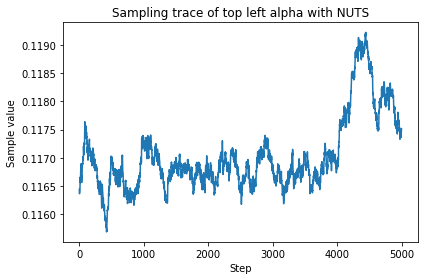

In [291]:
X = posterior_samples['concentration'][:,0,0,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

In [22]:
## Data preparation and cleaning
# importing required packages
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 30



Autosaving every 30 seconds


In [23]:
# import data and convert to python objects
# load Rdata object
rdata = pyreadr.read_r('tomtom_data/det_dfs.Rdata')
# pull out separate dataframes, one with choice text, the other with numeric responses
df = rdata['df']
dfn = rdata['dfn']
df.head()


# read in state labels
states = pd.read_csv('tomtom_data/states.csv')
states['statepair'] = states['state1'] + '_' + states['state2']# construct state pair strings
states.head()

# extract all the self ratings
ind_selfq1 = df.columns.get_loc('X1_Q12_1') # location of the first question
trans_self = df.iloc[:,list(range(ind_selfq1,(ind_selfq1+75)))]
print(trans_self.shape)
trans_self.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs
print(trans_self.columns[1:5])
trans_self.head()

(94, 75)
Index(['assertive_grouchy', 'assertive_sad', 'assertive_assertive',
       'assertive_unrestrained'],
      dtype='object')


,assertive_confident,assertive_grouchy,assertive_sad,assertive_assertive,assertive_unrestrained,confident_confident,confident_grouchy,confident_sad,confident_assertive,confident_unrestrained,...,love_satisfaction,love_love,love_contempt,love_disgust,love_embarrassment,satisfaction_satisfaction,satisfaction_love,satisfaction_contempt,satisfaction_disgust,satisfaction_embarrassment
0,92,45,43,95,89,97,38,57,90,77,...,92,95,23,13,44,94,99,27,16,45
1,65,50,10,60,100,65,5,40,90,55,...,95,100,20,20,30,100,50,10,60,40
2,80,61,36,70,70,79,10,35,82,81,...,85,90,9,11,75,96,76,25,24,75
3,85,65,10,75,75,75,10,15,85,85,...,95,95,5,5,15,90,90,5,5,10
4,90,70,33,84,80,87,25,22,90,85,...,87,87,14,10,26,85,78,29,9,16


In [46]:
## preparation
# set the constant for converting probability to frequency
freq_constant = 10000
# indexing autotransition columns
colnames = trans_self.columns.tolist()
cnsplit = [p.split('_') for p in colnames]
idx_autotransition = [p[0] == p[1] for p in cnsplit] # list of boolean, True = is autotransition


# 1. normalizing with autotransitions included, one df for probability, one converted to frequency
# initialize 2 dataframes
ts_norm_all = pd.DataFrame(columns=trans_self.columns, index = trans_self.index)
ts_norm_all_f =  pd.DataFrame(columns=trans_self.columns, index = trans_self.index)

# normalize by row-sum every five columns, since the columns are already arranged by from-state in 5
for i in range(0,trans_self.shape[1],5):
    dftemp = trans_self.iloc[:,i:(i+5)]
    dftemp_rowsum = dftemp.sum(axis = 1)
    normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
    ts_norm_all.iloc[:,i:(i+5)] = normed_cols
    ts_norm_all_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()

# 2. two additional dataframes: normed with auto transition but don't contain them
ts_norm_all_noauto = ts_norm_all.loc[:,[not t for t in idx_autotransition]]
ts_norm_all_noauto_f = ts_norm_all_f.loc[:,[not t for t in idx_autotransition]]

# 3. finally, normalizing without autotransitions, and also convert to frequency
trans_self_noauto = trans_self.loc[:,[not t for t in idx_autotransition]]
ts_norm_noauto = pd.DataFrame(columns=trans_self_noauto.columns, index = trans_self_noauto.index)
ts_norm_noauto_f = pd.DataFrame(columns=trans_self_noauto.columns, index = trans_self_noauto.index)

# normalize by row-sum every FOUR columns, grouped by from-state in 4 without autotransition
for i in range(0,trans_self_noauto.shape[1],4):
    dftemp = trans_self_noauto.iloc[:,i:(i+4)]
    dftemp_rowsum = dftemp.sum(axis = 1)
    normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
    ts_norm_noauto.iloc[:,i:(i+5)] = normed_cols
    ts_norm_noauto_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()


In [80]:
ts_norm_all_3d = torch.tensor(np.stack([np.array(ts_norm_all.iloc[0]).reshape(15,5) for i in np.arange(ts_norm_all.shape[0])]).astype('float32'))

In [81]:
ts_norm_all_3d.dtype


torch.float32

In [91]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def initialize(seed):           
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentration']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, ts_norm_all_3d)

loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(100)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 28, initial_loss = 11882.3486328125


In [92]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(3000):
    loss = svi.step(ts_norm_all_3d)
    print(loss)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

map_estimates = global_guide(data)
concentration = map_estimates['concentration']
# print('alphas = {}'.format(alphas.data.numpy()))
# print('betas = {}'.format(betas.data.numpy()))
print('concentrations = {}'.format(concentration.data.numpy()))

12670.775390625

12658.748046875
.12646.71484375
.12634.724609375
.12622.73046875
.12610.7490234375
.12598.783203125
.12586.83203125
.12574.90234375
.12562.990234375
.12551.08203125
.12539.1953125
.12527.3125
.12515.45703125
.12503.630859375
.12491.798828125
.12479.9931640625
.12468.203125
.12456.423828125
.12444.6708984375
.12432.923828125
.12421.205078125
.12409.5
.12397.80859375
.12386.13671875
.12374.474609375
.12362.845703125
.12351.2216796875
.12339.619140625
.12328.02734375
.12316.466796875
.12304.921875
.12293.3779296875
.12281.8583984375
.12270.3515625
.12258.8759765625
.12247.4072265625
.12235.966796875
.12224.529296875
.12213.1181640625
.12201.7236328125
.12190.3583984375
.12178.982421875
.12167.6416015625
.12156.328125
.12145.0205078125
.12133.7265625
.12122.451171875
.12111.1953125
.12099.95703125
.12088.740234375
.12077.541015625
.12066.3623046875
.12055.181640625
.12044.029296875
.12032.89453125
.12021.779296875
.12010.6845703125
.11999.599609375
.11988.533203125
.11977.

.8256.5302734375
.8250.4521484375
.8244.4052734375
.8238.359375
.8232.31640625
.8226.283203125
.8220.248046875
.8214.2265625
.8208.224609375
.8202.2080078125
.8196.21484375
.8190.22900390625
.8184.251953125
.8178.27978515625
.8172.31005859375
.8166.33984375
.8160.40380859375
.8154.470703125
.8148.52001953125
.8142.5908203125
.8136.6708984375
.8130.75390625
.8124.84814453125
.8118.96875
.8113.0615234375
.8107.19140625
.8101.3251953125
.8095.44384765625
.8089.5791015625
.8083.7265625
.8077.896484375
.8072.05322265625
.8066.2080078125
.8060.3984375
.8054.591796875
.8048.7578125
.8042.962890625
.8037.166015625
.8031.38671875
.8025.619140625
.8019.83935546875
.8014.08154296875
.8008.3095703125
.8002.5654296875
.7996.82958984375
.7991.09375
.7985.36083984375
.7979.6376953125
.7973.9365234375
.7968.2177734375
.7962.53271484375
.7956.85009765625
.7951.1474609375
.7945.4755859375
.7939.8203125
.7934.15283203125
.7928.49072265625
.7922.8349609375
.7917.20458984375
.7911.57421875
.7905.9350585937

.5991.650390625
.5988.5048828125
.5985.3525390625
.5982.2177734375
.5979.076171875
.5975.9404296875
.5972.81640625
.5969.6884765625
.5966.5673828125
.5963.4619140625
.5960.349609375
.5957.234375
.5954.1240234375
.5951.02734375
.5947.935546875
.5944.8291015625
.5941.7392578125
.5938.6591796875
.5935.5791015625
.5932.498046875
.5929.423828125
.5926.3642578125
.5923.2900390625
.5920.2236328125
.5917.154296875
.5914.1005859375
.5911.0556640625
.5908.01171875
.5904.95703125
.5901.91796875
.5898.89453125
.5895.8427734375
.5892.8212890625
.5889.7919921875
.5886.7646484375
.5883.755859375
.5880.732421875
.5877.7255859375
.5874.724609375
.5871.72265625
.5868.72265625
.5865.7255859375
.5862.7314453125
.5859.7412109375
.5856.7685546875
.5853.78125
.5850.794921875
.5847.814453125
.5844.8515625
.5841.8896484375
.5838.927734375
.5835.970703125
.5833.0107421875
.5830.0576171875
.5827.111328125
.5824.1630859375
.5821.2099609375
.5818.2666015625
.5815.34375
.5812.4033203125
.5809.4794921875
.5806.5625


.4767.0693359375
.4765.2685546875
.4763.4658203125
.4761.6640625
.4759.87890625
.4758.0986328125
.4756.2998046875
.4754.525390625
.4752.7275390625
.4750.9423828125
.4749.1455078125
.4747.3779296875
.4745.6015625
.4743.8056640625
.4742.05078125
.4740.2607421875
.4738.484375
.4736.7119140625
.4734.947265625
.4733.1728515625
.4731.4013671875
.4729.6376953125
.4727.8681640625
.4726.103515625
.4724.3583984375
.4722.5791015625
.4720.830078125
.4719.0673828125
.4717.3076171875
.4715.5595703125
.4713.7998046875
.4712.06640625
.4710.28515625
.4708.5673828125
.4706.8046875
.4705.068359375
.4703.3134765625
.4701.5771484375
.4699.8251953125
.4698.0927734375
.4696.3603515625
.4694.6083984375
.4692.8740234375
.4691.138671875
.4689.4111328125
.4687.6806640625
.4685.9326171875
.4684.220703125
.4682.47265625
.4680.7509765625
.4679.0400390625
.4677.29296875
.4675.59375
.4673.8701171875
.4672.1689453125
.4670.4228515625
.4668.705078125
.4667.0048828125
.4665.28125
.4663.55859375
.4661.8583984375
.4660.14

.3979.853515625
.3978.46875
.3977.064453125
.3975.69140625
.3974.3037109375
.3972.9033203125
.3971.515625
.3970.1337890625
.3968.75
.3967.3525390625
.3965.9619140625
.3964.591796875
.3963.2041015625
.3961.802734375
.3960.4140625
.3959.0419921875
.3957.654296875
.3956.2490234375
.3954.869140625
.3953.4921875
.3952.107421875
.3950.7099609375
.3949.32421875
.3947.9443359375
.3946.5595703125
.3945.1611328125
.3943.783203125
.3942.4130859375
.3941.0234375
.3939.623046875
.3938.244140625
.3936.87109375
.3935.4794921875
.3934.083984375
.3932.697265625
.3931.3310546875
.3929.951171875
.3928.5703125
.3927.1650390625
.3925.791015625
.3924.4072265625
.3923.009765625
.3921.6279296875
.3920.259765625
.3918.8759765625
.3917.4794921875
.3916.09765625
.3914.7412109375
.3913.3427734375
.3911.9453125
.3910.5654296875

3909.19140625
.3907.8095703125
.3906.4169921875
.3905.0361328125
.3903.6650390625
.3902.2861328125
.3900.8837890625
.3899.5029296875
.3898.1513671875
.3896.7529296875
.3895.357421875
.3893

.3278.5908203125
.3277.2265625
.3275.87890625
.3274.5068359375
.3273.1904296875
.3271.8232421875
.3270.4765625
.3269.1044921875
.3267.77734375
.3266.4287109375
.3265.0615234375
.3263.712890625
.3262.345703125
.3261.0283203125
.3259.6640625
.3258.296875
.3256.94921875
.3255.6171875
.3254.267578125
.3252.90234375
.3251.5576171875
.3250.1943359375
.3248.859375
.3247.5126953125
.3246.1455078125
.3244.7783203125
.3243.4326171875
.3242.115234375
.3240.751953125
.3239.3857421875
.3238.0439453125
.3236.7080078125
.3235.365234375
.3233.998046875
.3232.6318359375
.3231.2880859375
.3229.9521484375
.3228.607421875

3227.2451171875
.3225.8955078125
.3224.5673828125
.3223.220703125
.3221.8544921875
.3220.5068359375
.3219.14453125
.3217.8134765625
.3216.466796875
.3215.1005859375
.3213.75390625
.3212.392578125
.3211.0771484375
.3209.716796875
.3208.35546875
.3207.0068359375
.3205.6728515625
.3204.3271484375
.3202.9697265625
.3201.62109375
.3200.291015625
.3198.9228515625
.3197.580078125
.3196.2392578

In [93]:
map_estimates['weights']

tensor([0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.1678, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084, 0.0084,
        0.0084], grad_fn=<ExpandBackward>)

In [ ]:
# generate predictions and compare againts real data (posterior predictive check)

In [ ]:
# umap visualization

In [ ]:
# different normalization and autotransition stuff